# Computer Vision Coursework

In [1]:
### Importing necessary libraries
import os
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import time

## Exploratory Data Analysis

### Basic Stats

In [2]:
### Loading matlab files in Python using Scipy
import scipy.io
mat = scipy.io.loadmat('Brain.mat')

In [3]:
T1, label = mat['T1'], mat['label']

In [4]:
### T1 is the array with the input MRI images, 10 samples each of size 362x434 pixels.
T1.shape

(362, 434, 10)

In [5]:
### range of pixel values in a sample of T1
sample = T1[:,:,0]
print(f"""Max pixel value: {round(sample.min(),0)}, 
Min pixel value: {round(sample.max(),0)},
Average pixel value: {round(sample.mean(),0)}""")

Max pixel value: 959.0, 
Min pixel value: 491434.0,
Average pixel value: 164930.0


- From the above cell, we can see that the obtained input image is not in standard color range `0-255`. Thus, we need to apply the standardisation technique `(x -> (x-xmin)/(xmax-xmin))` that will convert the pixel to the range `[0,1]`. Multiply the obtained pixel values with 255 and take the integer value to get the standard `0-255` representation of the image

In [6]:
sample_std = ((sample - sample.min()) * (1/(sample.max() - sample.min()) * 255)).astype('uint8')
print(f"""Standardized image:
Max pixel value: {round(sample_std.min(),0)}, 
Min pixel value: {round(sample_std.max(),0)},
Average pixel value: {round(sample_std.mean(),0)}""")

Standardized image:
Max pixel value: 0, 
Min pixel value: 255,
Average pixel value: 85.0


### Visualising images

In [7]:
### function to plot single image
def show_image(image,cmap = 'gray',fig_size = 5):
    plt.figure(figsize = (fig_size,fig_size))
    fig  = plt.imshow(image,cmap = cmap)
    plt.show()

### function to visualise label images
def imshow_components(labels):
    # Map component labels to hue val
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])
    # convert hsv2bgr for visualsiation
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)
    # set background label to black
    labeled_img[label_hue==0] = 0
    return labeled_img

### function to plot multiple images as subplot
def plot_multi(images, cmap='gray', fig_size = 20):
    plt.figure(figsize=(fig_size, fig_size))
    length = len(images)
    sq_root = int(length**0.5)
    for i in range(length):
        plt.subplot(sq_root+1,sq_root+1,i+1)
        plt.imshow(images[i],cmap = cmap)
        plt.xlabel(f"index: {i+1}")


#### Plotting original image and Standardised image to check for data loss

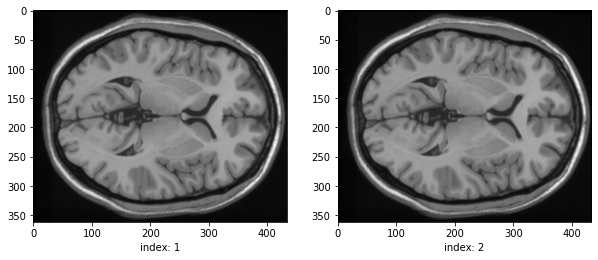

In [8]:
plot_multi([sample, sample_std],fig_size=10)

### Storing the images for understanding the data better

In [9]:
### creating a folder to store images
data_folder = 'data'
os.makedirs('data',exist_ok=True)

In [10]:
images = []
labels = []
for i in range(10):
    img = T1[:,:,i]
    
    ### standardising the float values between int of range(0-255)
    img = ((img - img.min()) * (1/(img.max() - img.min()) * 255)).astype('uint8')
    images.append(img)
    lab = label[:,:,i]
    labels.append(lab)
#     lab1 = ((lab - lab.min()) * (1/(lab.max() - lab.min()) * 255)).astype('uint8')
    lab1 = imshow_components(lab)
    cv2.imwrite(os.path.join(data_folder,f'{i}_image.png'),img)
    cv2.imwrite(os.path.join(data_folder,f'{i}_gt.png'),lab)
    cv2.imwrite(os.path.join(data_folder,f'{i}_image_gt.png'),lab1)
    
###reference: https://stackoverflow.com/a/49922520/9605907

In [11]:
### listing the created images in the data folder
sorted(os.listdir(data_folder))[0:10]

['.DS_Store',
 '0_gt.png',
 '0_image.png',
 '0_image_gt.png',
 '1_gt.png',
 '1_image.png',
 '1_image_gt.png',
 '2_gt.png',
 '2_image.png',
 '2_image_gt.png']

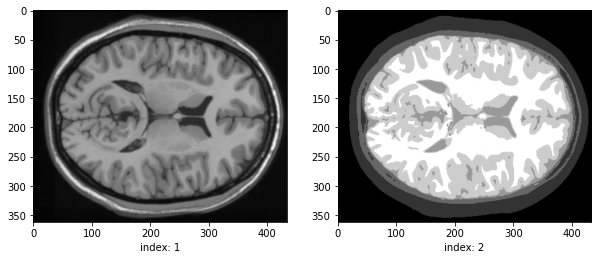

In [12]:
### Visualising a sample input image and it's expected groundtruth
plot_multi([images[9],labels[9]],cmap = 'gray',fig_size=10)

### Segementation classes

- For a given MRI image, we need to segment them into 6 categories namely: air, skin, skull, csf, gray matter and white matter

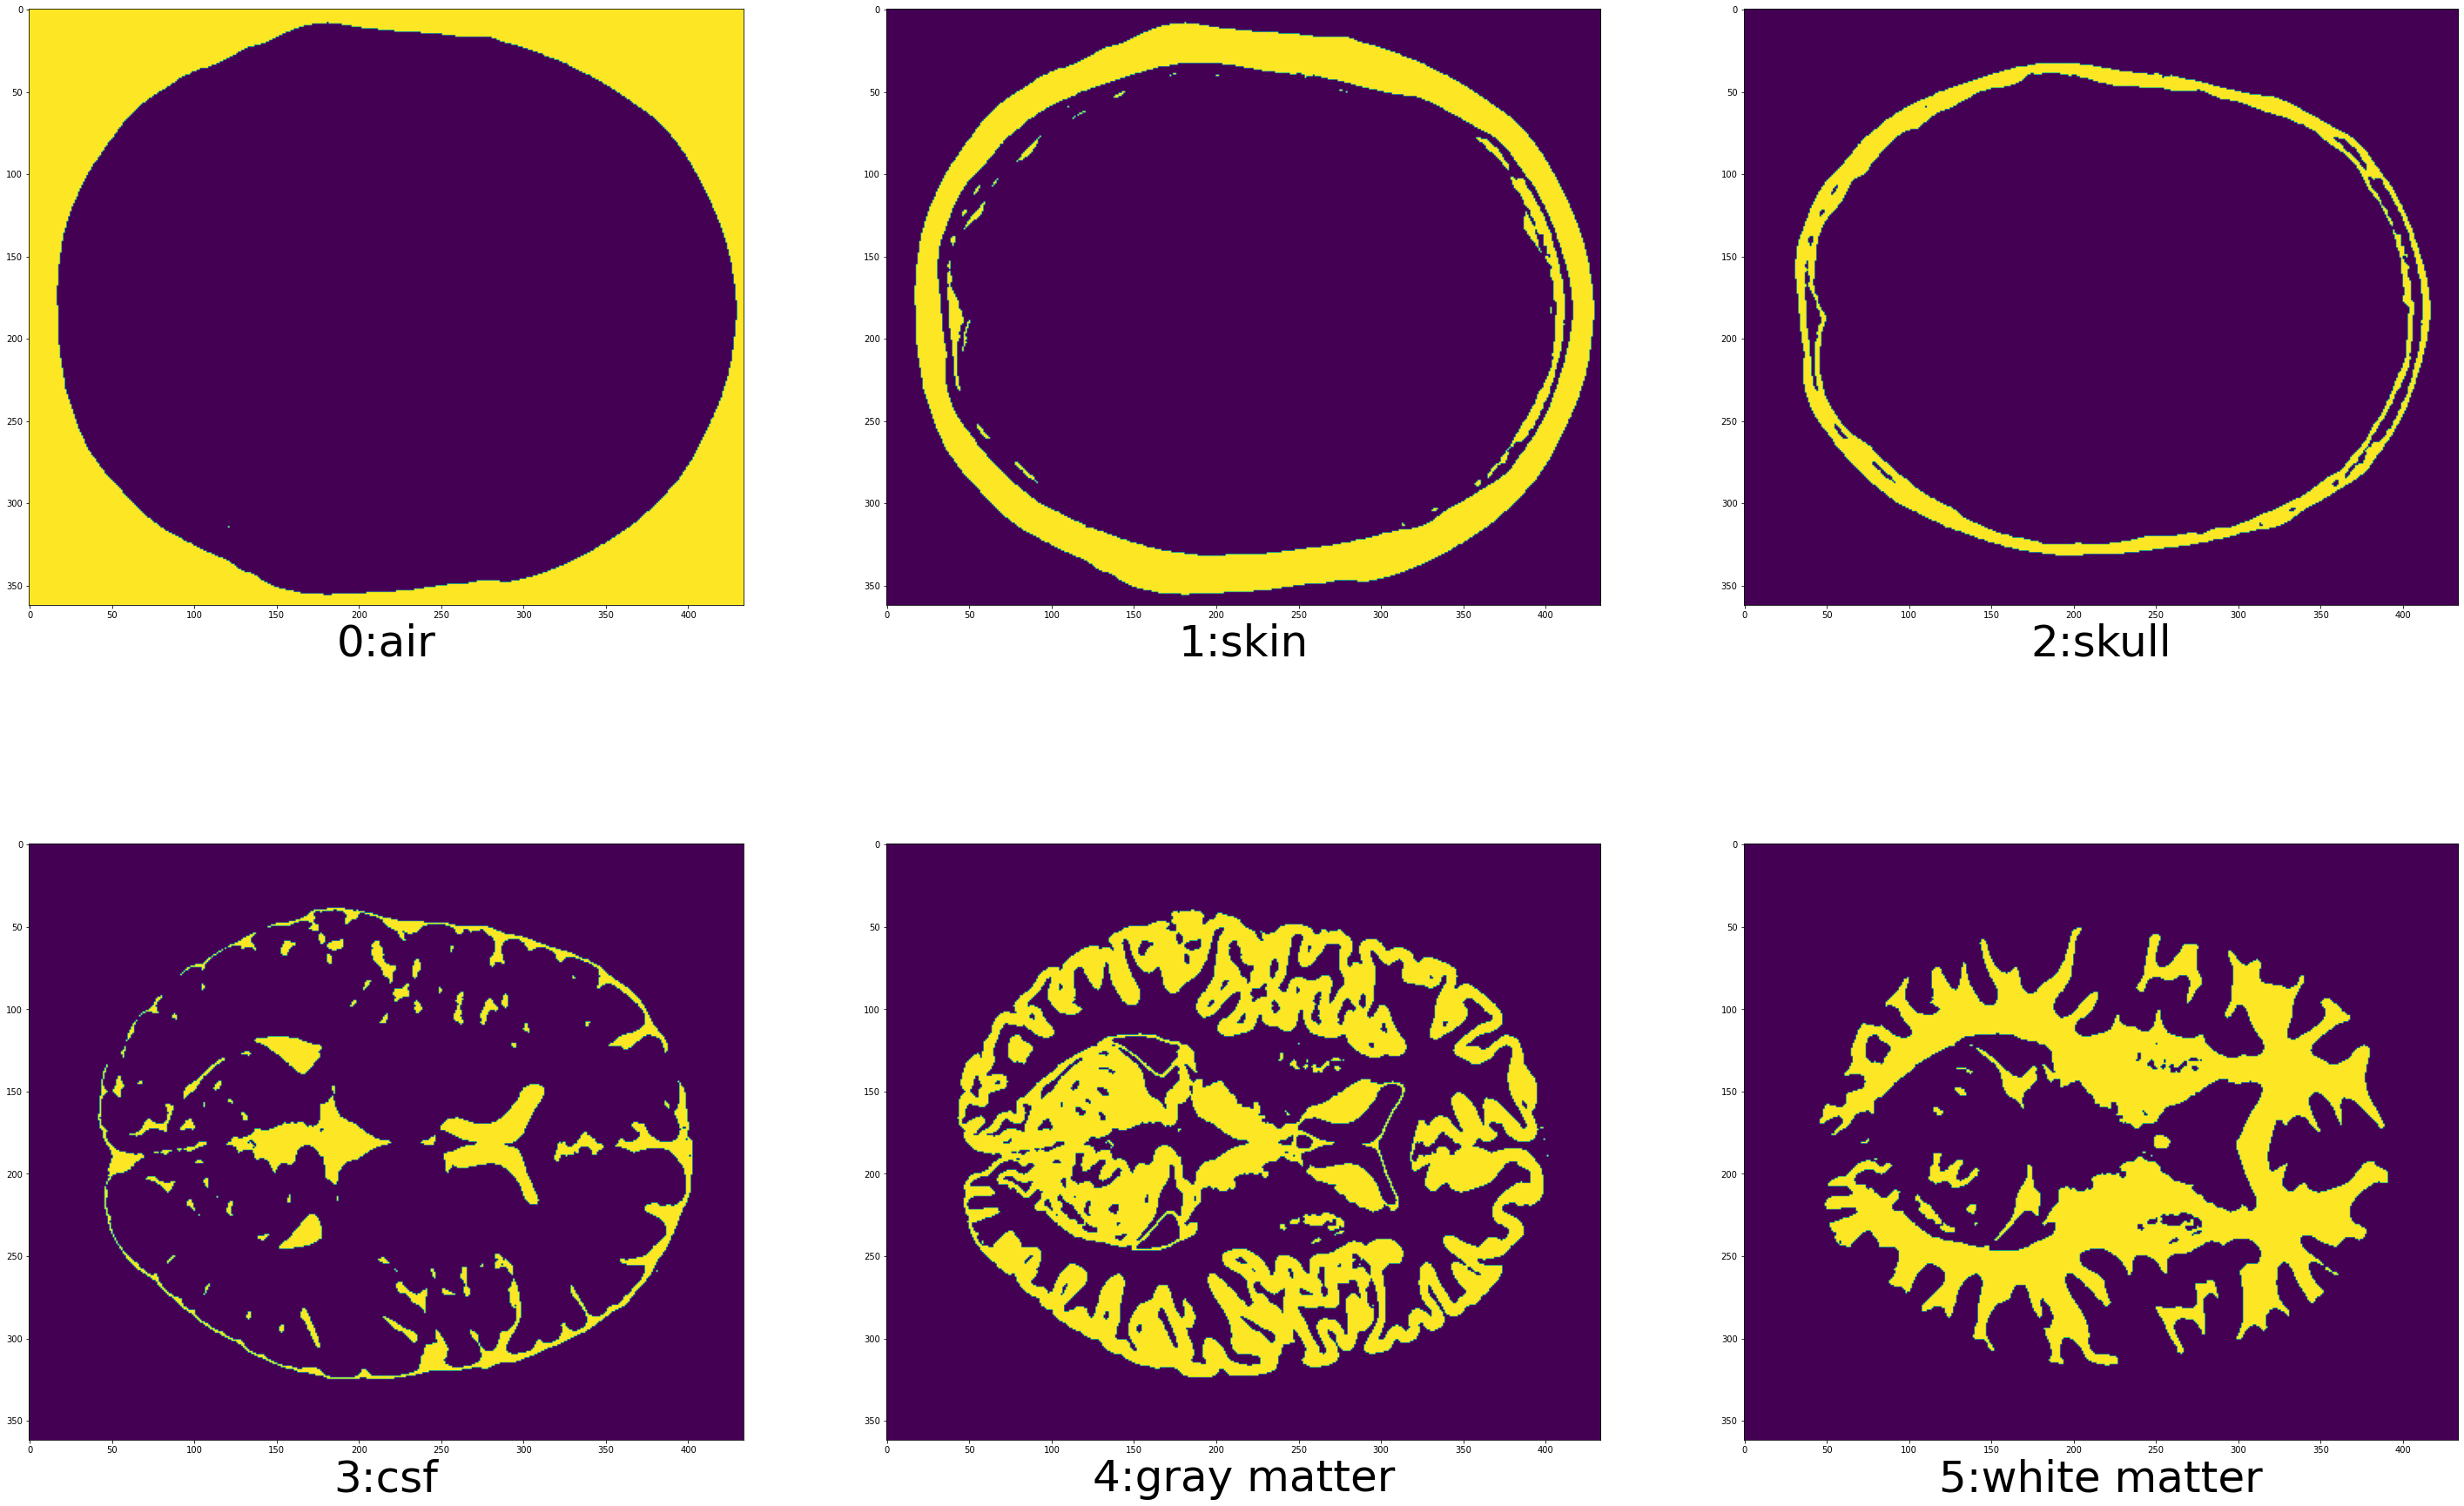

In [13]:
input_image = images[5]
label_image = labels[5]
label_index = {0:'air',1:'skin',2:'skull',3:'csf',4:'gray matter',5:'white matter'}
plt.figure(figsize=(50, 50))
for i in range(6):
    plt.subplot(3,3,i+1)
    plt.imshow(label_image==i)
    plt.xlabel(f"{i}:{label_index[i]}",fontsize=50)

## Evaluating the performance
- Before we move on to different approaches in obtaining the segmentation, we will first define the evaluation metrics and get an accuracy measure with the groundtruth and verify the logics. 

In [14]:
def pixelwise_IOU_label(input_image, ground_truth, label_class = 1):
    mask1 = input_image == label_class
    mask2 = ground_truth == label_class
    iou_score = IOU_binary(mask1, mask2)
    return iou_score

In [15]:
def IOU_binary(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

In [16]:
def dice_binary(mask1, mask2):
    mask1_pos = mask1.astype(np.float32)
    mask2_pos = mask2.astype(np.float32)
    dice = 2 * np.sum(mask1_pos * mask2_pos) / (np.sum(mask1_pos) + np.sum(mask2_pos))
    return dice

In [17]:
# def categorical_dice_label(mask1, mask2, label_class = 1):
#     """
#     Dice score of a specified class between two volumes of label masks.
#     (classes are encoded but by label class number not one-hot )
#     Note: stacks of 2D slices are considered volumes.

#     Args:
#         mask1: N label masks, numpy array shaped (H, W, N)
#         mask2: N label masks, numpy array shaped (H, W, N)
#         label_class: the class over which to calculate dice scores

#     Returns:
#         volume_dice
#     """
#     mask1_pos = (mask1 == label_class).astype(np.float32)
#     mask2_pos = (mask2 == label_class).astype(np.float32)
#     dice = dice_binary(mask1_pos,mask2_pos)
#     return dice

In [18]:
def score_image(predict, label):
    label_index = {0:'air',1:'skin',2:'skull',3:'csf',4:'gray matter',5:'white matter'}
    scores = []
    for pix_val, category in label_index.items():
        predict_mask = (predict == pix_val)
        label_mask = (label == pix_val)        
        dice = dice_binary(predict_mask, label_mask)
        scores.append(dice)
    return scores

In [104]:
import pandas as pd

def score_images(predicts, labels):
    df = pd.DataFrame(columns=['air','skin','skull','csf','gray matter','white matter','average'])
    for i, (predict, label) in enumerate(zip(predicts,labels)):
        scores = calculate_dice(predict,label)
        scores.append(sum(scores)/len(scores))
        df.loc[i] = scores
    print("Dice scores:")
    for label in df.columns:
        print(f"{label} : {df[label].mean()}")
    return df
def score_images(predicts, labels):
    df = pd.DataFrame(columns=['air','skin','skull','csf','gray matter','white matter','0_mean'])
    for i, (predict, label) in enumerate(zip(predicts,labels)):
        scores = score_image(predict,label)
        scores.append(sum(scores)/len(scores))
        df.loc[i] = scores
    print("Dice scores:")
    for label in df.columns:
        print(f"{label} : {df[label].mean()}")
    return df
df = score_images(labels,labels)
df

Dice scores:
air : 1.0
skin : 1.0
skull : 1.0
csf : 1.0
gray matter : 1.0
white matter : 1.0
0_mean : 1.0


,air,skin,skull,csf,gray matter,white matter,0_mean
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5,1.0,1.0,1.0,1.0,1.0,1.0,1.0
6,1.0,1.0,1.0,1.0,1.0,1.0,1.0
7,1.0,1.0,1.0,1.0,1.0,1.0,1.0
8,1.0,1.0,1.0,1.0,1.0,1.0,1.0
9,1.0,1.0,1.0,1.0,1.0,1.0,1.0


### Plotting Histogram of a sample image 

(0.0, 256.0)

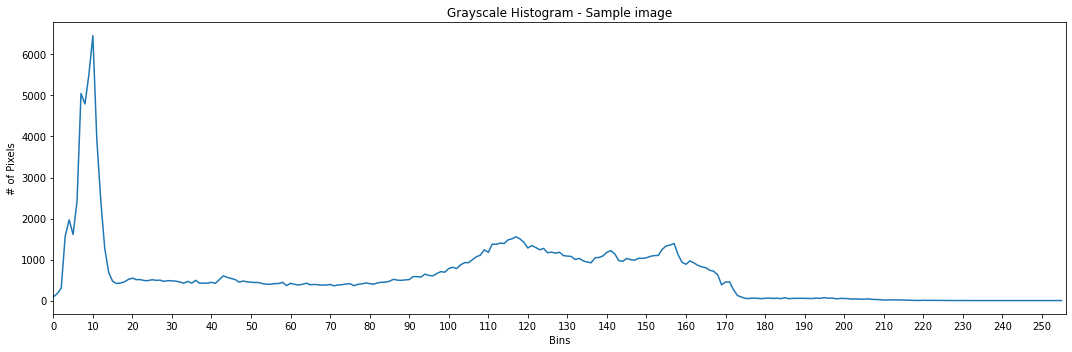

In [105]:
blur_image = cv2.GaussianBlur(input_image,(5,5),cv2.BORDER_DEFAULT)
hist = cv2.calcHist([blur_image], [0], None, [256], [0, 256])
plt.rcParams["figure.figsize"] = [15,5]
plt.rcParams["figure.autolayout"] = True
plt.figure()
plt.title("Grayscale Histogram - Sample image")
plt.xlabel("Bins")
plt.xticks(list(range(0,255,10)))
plt.ylabel("# of Pixels")
plt.plot(hist)
plt.xlim([0, 256])

- From the histogram, we can see that there are some peaks which might be representing a particular class of interest

- To arrive at thresholds which will hold for all 10 images, creating an average image and taking the histogram

In [106]:
avg_image = np.mean(images, axis=0).astype(np.uint8)
avg_image.shape

(362, 434)

(0.0, 256.0)

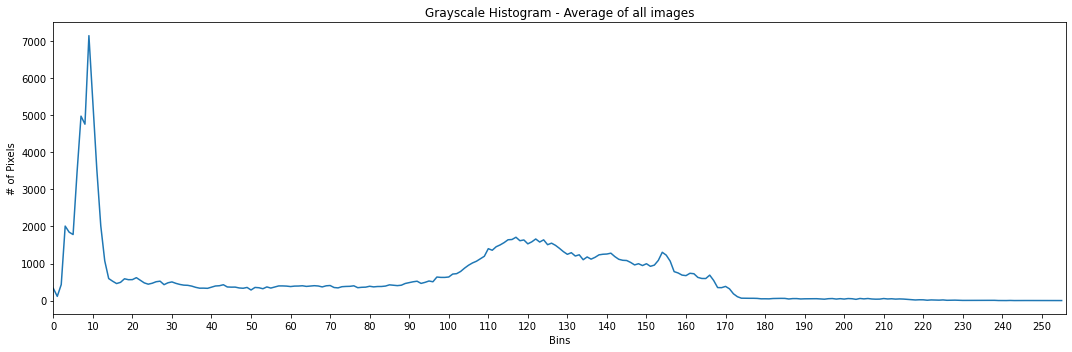

In [107]:
hist = cv2.calcHist([avg_image], [0], None, [256], [0, 256])
plt.rcParams["figure.figsize"] = [15,5]
plt.rcParams["figure.autolayout"] = True
plt.figure()
plt.title("Grayscale Histogram - Average of all images")
plt.xlabel("Bins")
plt.xticks(list(range(0,255,10)))
plt.ylabel("# of Pixels")
plt.plot(hist)
plt.xlim([0, 256])

In [108]:
### evaluating for each class
def match_and_score(predict_image, label_image):
    label_list = np.unique(predict_image)
    label_index = {0:'air',1:'skin',2:'skull',3:'csf',4:'gray matter',5:'white matter'}
    dice_score = []
    match_dict = {}
    score = {}
    dice_scores = []
    for l in label_list:
        ground_list = []
        max_score = 0
        for k in label_index.keys():
            iou = IOU_binary(predict_image == l, label_image == k)
            dice = dice_binary(predict_image == l, label_image == k)
            ground_list.append(dice)
        dice_scores.append(ground_list)
    df = pd.DataFrame(dice_scores)
    return df

## MRI Segementation - Approach 1 : K-means Clustering

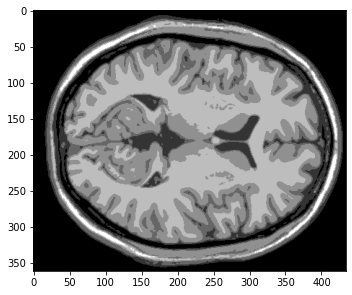

In [109]:
#### method 1
from skimage import io
from sklearn import cluster
import matplotlib.pyplot as plt

image = input_image.copy()
h, w = image.shape
# reshape to 1D array
image_2d = image.reshape(h*w,1)

image_2d = np.float32(image_2d)

### using cv2 kmeans
### In criteria, we first set the algorithm termination criteria, either max no of iterations or desired result 
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 50, 1.0)
K = 6
attempts = 100
ret,label,center=cv2.kmeans(image_2d,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
center = np.uint8(center)
res = center[label.flatten()]
result_image = res.reshape((image.shape))
show_image(result_image)
# print()

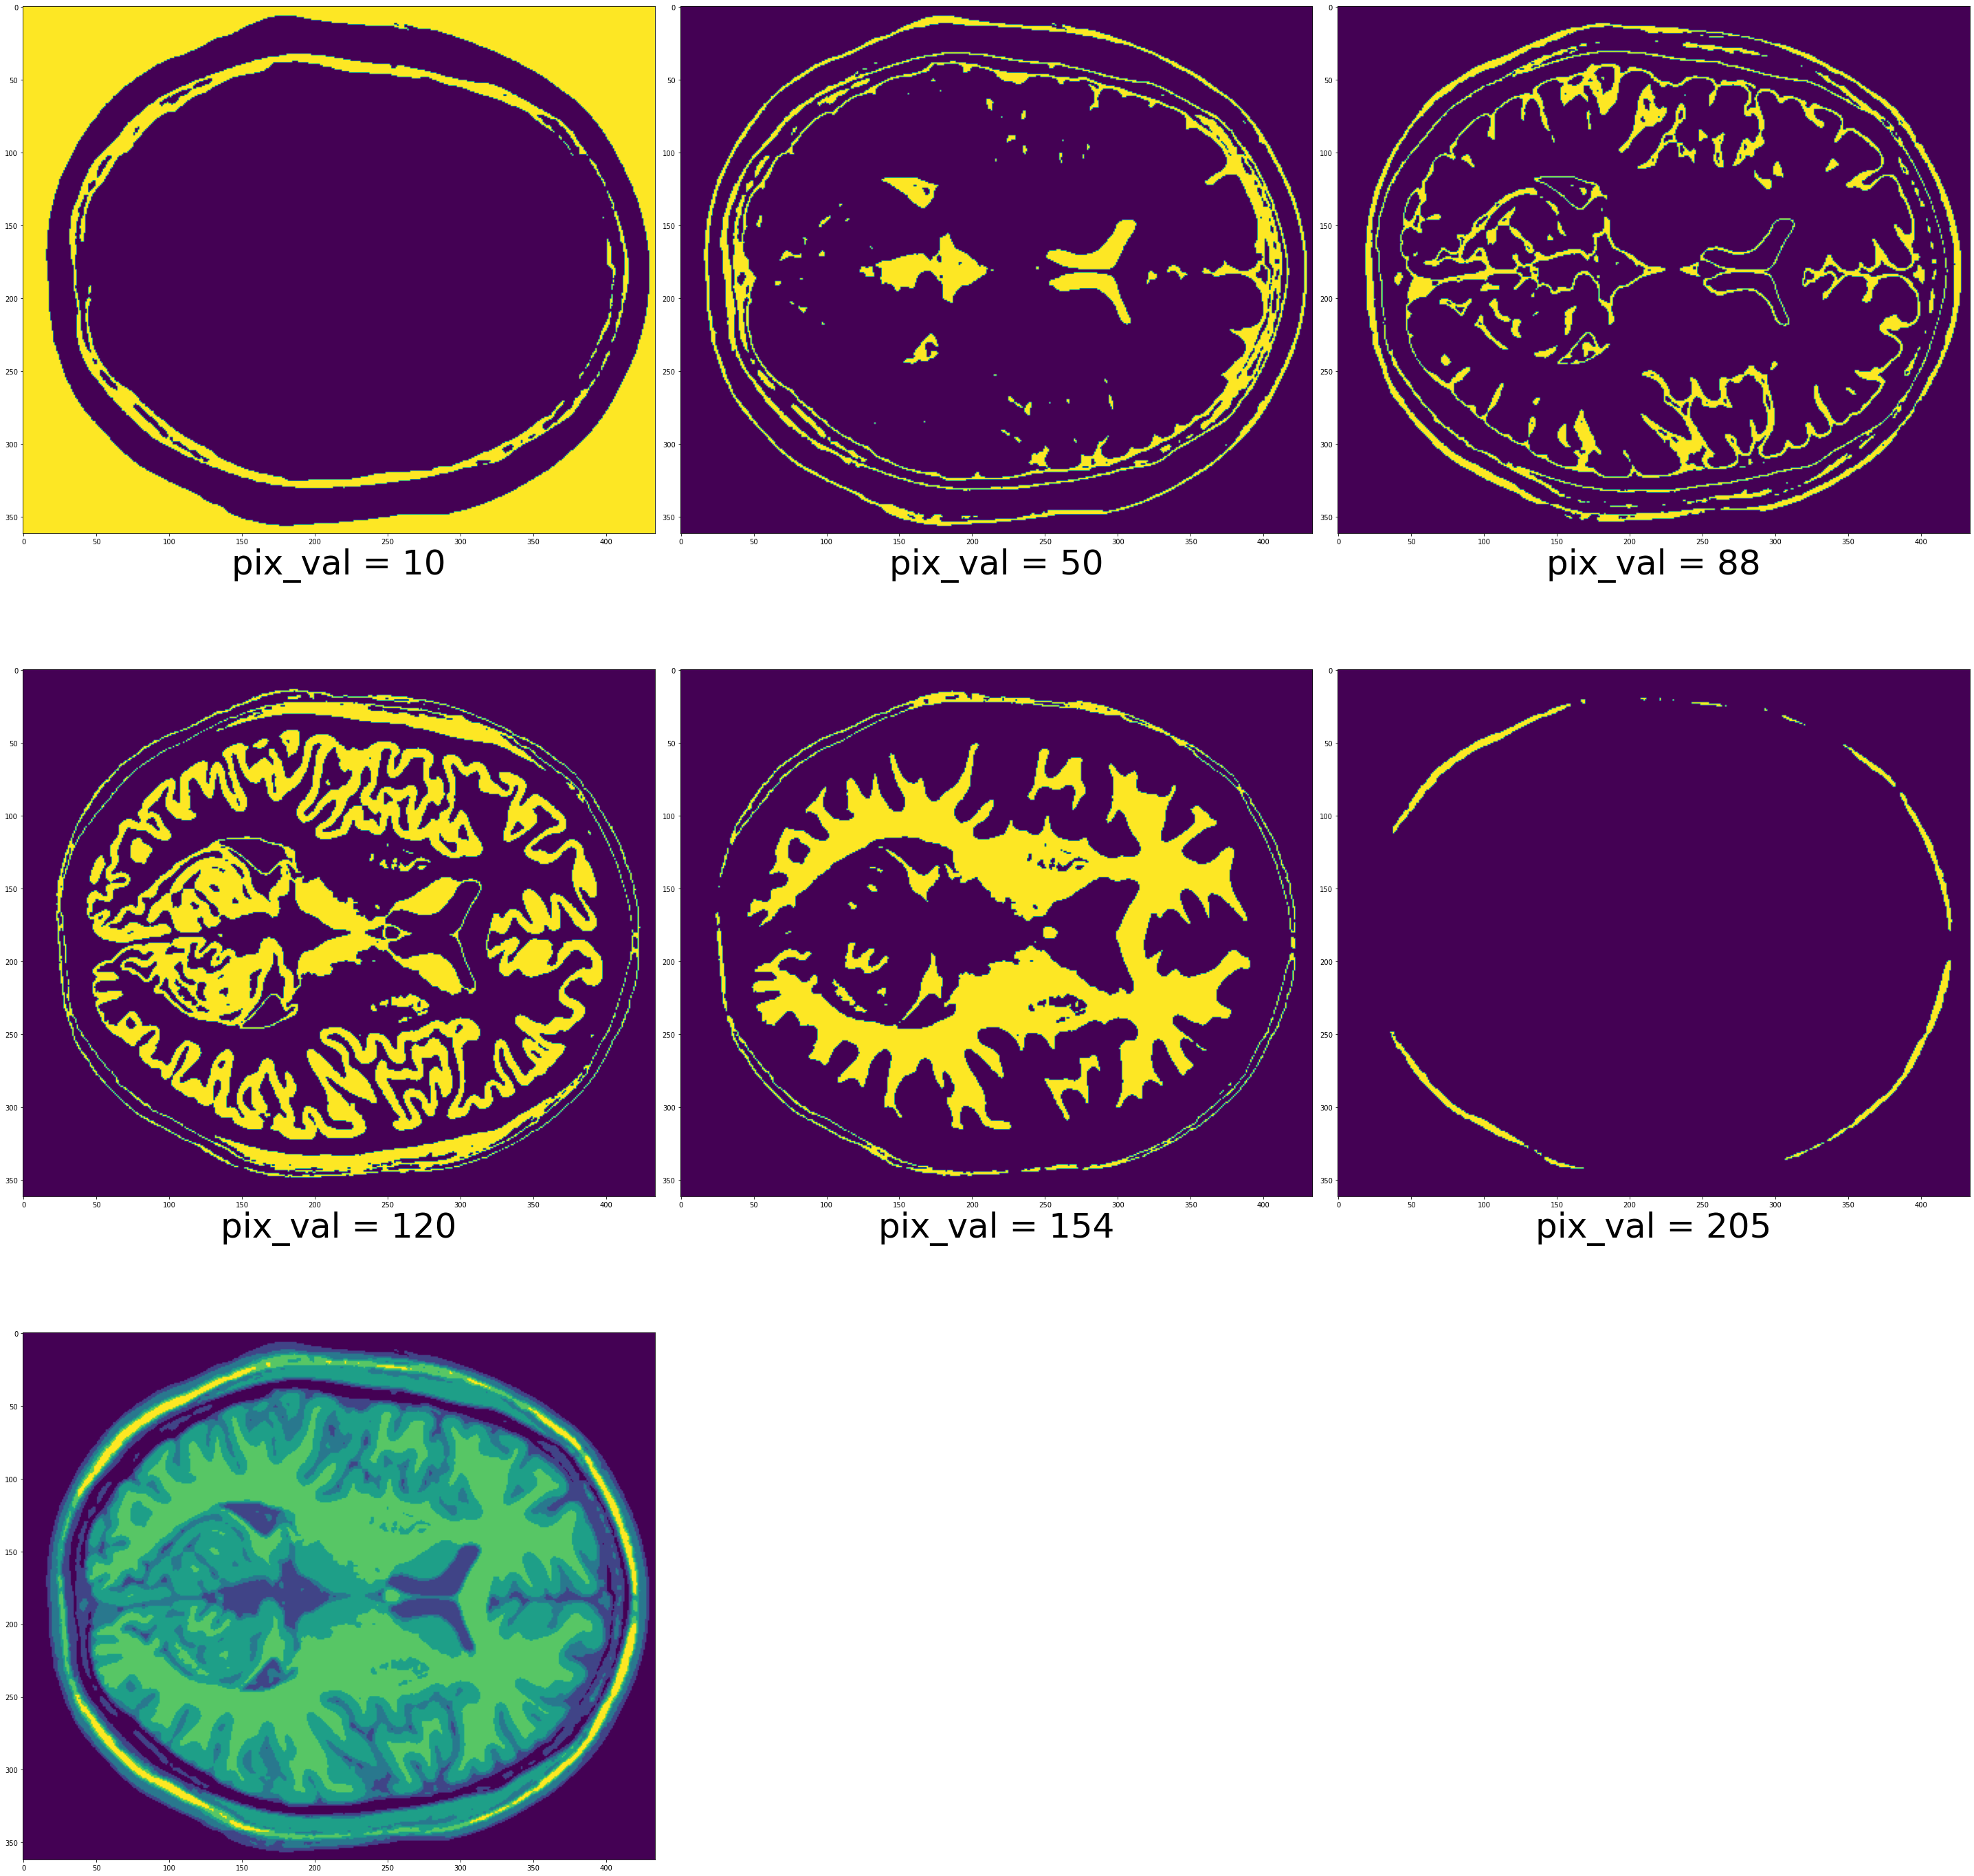

In [110]:
# label_index = {0:'air',1:'skin',2:'skull',3:'csf',4:'gray matter',5:'white matter'}
plt.figure(figsize=(40, 40))
np.unique(result_image)
for i,code in enumerate(np.unique(result_image)):
    plt.subplot(3,3,i+1)
    plt.imshow(result_image==code)
    plt.xlabel(f"pix_val = {code}",fontsize=50)
plt.subplot(3,3,i+2)
plt.imshow(result_image)


In [111]:
def kmeans_segmentation(input_image, no_of_classes = 6):
    h, w = input_image.shape
    # reshape to 1D array
    image_2d = input_image.reshape(h*w,1)

    image_2d = np.float32(image_2d)

    ### using cv2 kmeans
    ### In criteria, we first set the algorithm termination criteria, either max no of iterations or desired result 
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 50, 1.0)
    K = no_of_classes
    attempts = 100
    ret,label,center=cv2.kmeans(image_2d,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
    center = np.uint8(center)
    res = center[label.flatten()]
    result_image = res.reshape((image.shape))
    ### assigning each cluster to a label based on the range of pixels
    out_image = np.zeros_like(result_image)
    ## background
    # out_image = np.where(result_image<15, 0, out_image)
    ## 
    out_image = np.where(((result_image>45) & (result_image<55)), 1, out_image )
    out_image = np.where(((result_image>75) & (result_image<95)), 3, out_image )
    out_image = np.where(((result_image>115) & (result_image<135)), 4, out_image )
    out_image = np.where(((result_image>145) & (result_image<160)), 5, out_image )
    out_image = np.where(((result_image>200) & (result_image<210)), 2, out_image )
    
    return out_image
#     show_image(result_image)

In [112]:
out_image = kmeans_segmentation(input_image)
score_image(out_image,label_image)

[0.9174928434850846,
 0.24644913627639156,
 0.0,
 0.29255878660378,
 0.8133713278045415,
 0.9483606934289787]

In [113]:
predicts = list(map(lambda x:kmeans_segmentation(x),images))
df = score_images(predicts, labels)
df

Dice scores:
air : 0.9146817160010221
skin : 0.24510827491648451
skull : 0.0
csf : 0.2900282285198422
gray matter : 0.8193940897659291
white matter : 0.9505443567888753
0_mean : 0.5366261109986923


,air,skin,skull,csf,gray matter,white matter,0_mean
0,0.913326,0.252482,0.0,0.249963,0.822218,0.957070,0.532510
1,0.915005,0.235178,0.0,0.294556,0.828215,0.955768,0.538120
2,0.913147,0.247475,0.0,0.274664,0.820723,0.955064,0.535179
3,0.914967,0.246446,0.0,0.283869,0.821247,0.953972,0.536750
4,0.917755,0.234039,0.0,0.315699,0.821038,0.943748,0.538713
5,0.915257,0.256062,0.0,0.283103,0.813371,0.948361,0.536026
6,0.913055,0.256211,0.0,0.297002,0.816952,0.951727,0.539158
7,0.914220,0.245738,0.0,0.304429,0.824135,0.952217,0.540123
8,0.914887,0.245778,0.0,0.291453,0.812710,0.944525,0.534892
9,0.915198,0.231674,0.0,0.305545,0.813333,0.942992,0.534790


In [114]:
df_kmeans = df

In [115]:
score_image(out_image,label_image)

[0.9174928434850846,
 0.24644913627639156,
 0.0,
 0.29255878660378,
 0.8133713278045415,
 0.9483606934289787]

## MRI Segmentation - Approach 2 : Filtering & Morphological operations

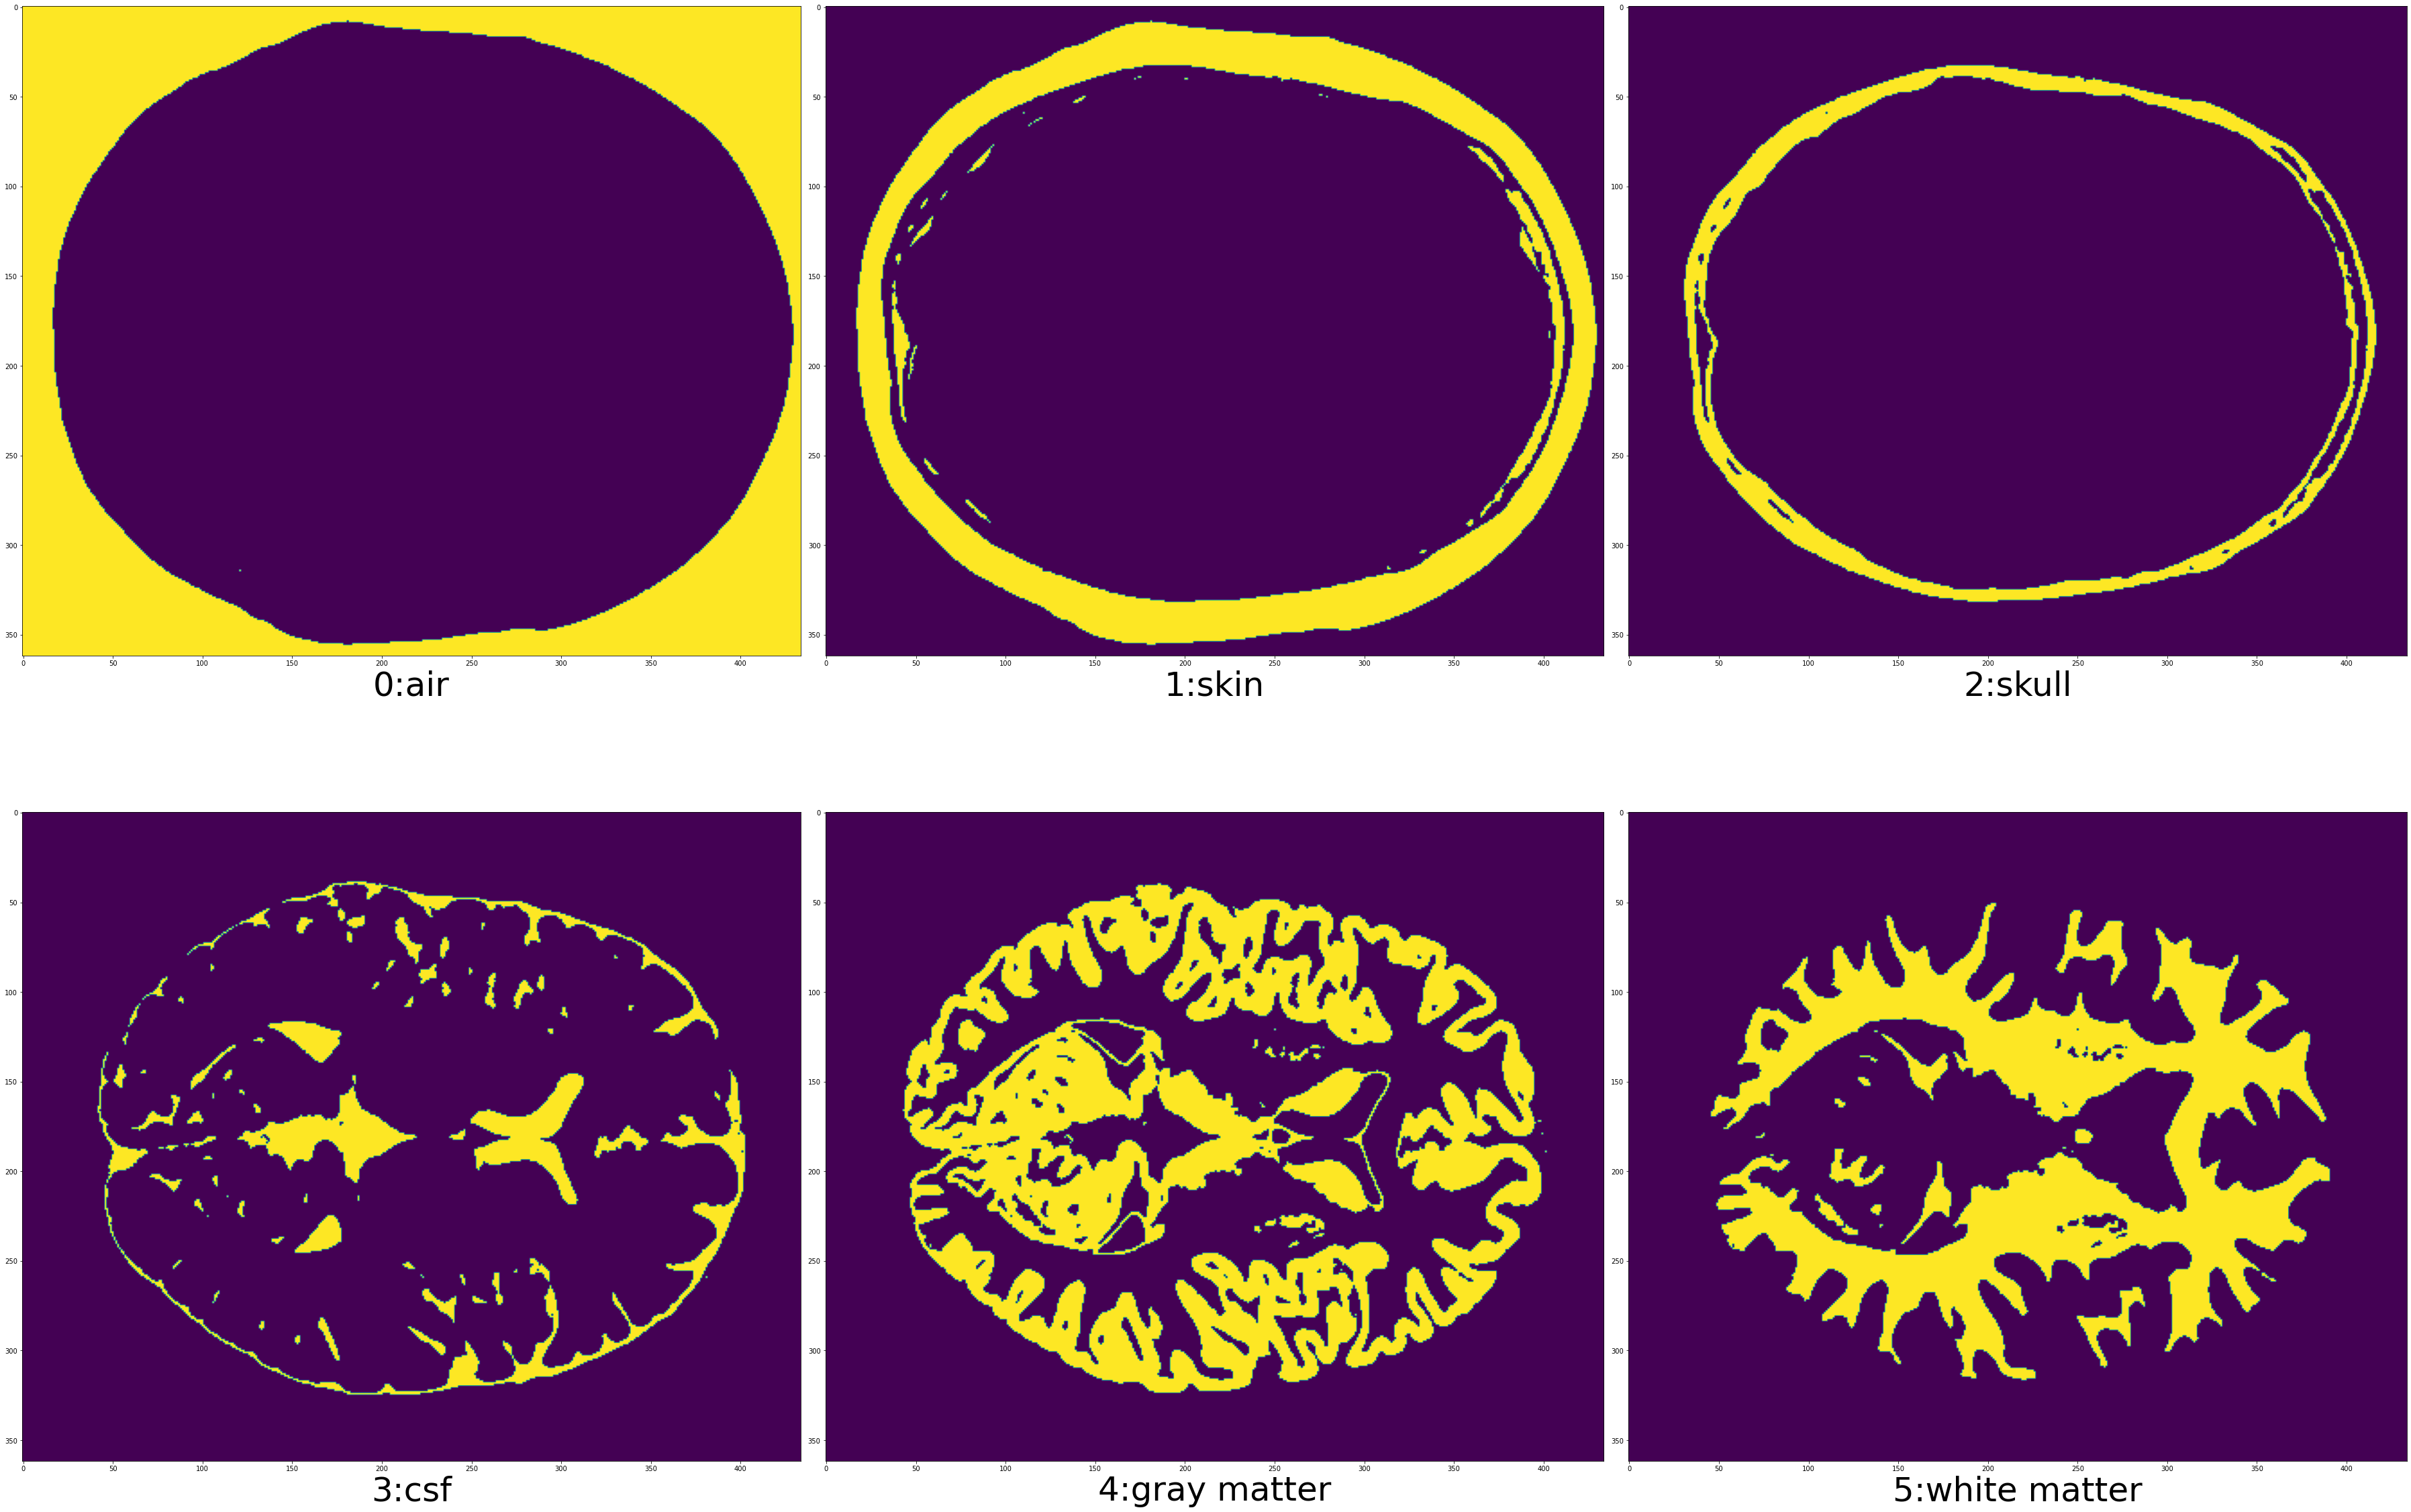

In [116]:
label_index = {0:'air',1:'skin',2:'skull',3:'csf',4:'gray matter',5:'white matter'}
plt.figure(figsize=(50, 50))
for i in range(6):
    plt.subplot(3,3,i+1)
    plt.imshow(label_image==i)
    plt.xlabel(f"{i}:{label_index[i]}",fontsize=50)

#### Approach 3: Final function

In [117]:
def filter_noise_label(out_label):
    for i in np.unique(out_label):
        if np.count_nonzero(out_label==i)<(0.1*out_label.shape[0]*out_label.shape[1]):
            out_label = np.where(out_label==i,0,out_label)
    return out_label

def class_wise_segmentation(input_image, intermediate = False):
    ### applying a 5x5 Gaussian blur to 
    blur_image = cv2.GaussianBlur(input_image.copy(),(5,5),cv2.BORDER_DEFAULT)
    out_image = np.zeros_like(label_image)
    ### air
    _, air = cv2.threshold(blur_image, 17 , 255, cv2.THRESH_BINARY)
    kernel = np.ones((5,5),dtype=np.uint8)
    air_mask = ~cv2.morphologyEx(air, cv2.MORPH_CLOSE, kernel,iterations = 1)
    air_mask = cv2.morphologyEx(air_mask, cv2.MORPH_DILATE, kernel, iterations =5)

    ### skin
    th, skin = cv2.threshold(blur_image, 50, 255, cv2.THRESH_BINARY)
    kernel = np.ones((5,5),dtype=np.uint8)
    dst2_open = cv2.morphologyEx(skin, cv2.MORPH_OPEN, kernel,iterations = 1)
    retval, out_label, stats, centroids = cv2.connectedComponentsWithStats(dst2_open)
    skin_mask = (out_label==1).astype(np.uint8)
    kernel = np.ones((3,3),dtype=np.uint8)
    skin_mask = cv2.morphologyEx(skin_mask, cv2.MORPH_DILATE, kernel,iterations = 1)
    out_label = filter_noise_label(out_label)
    out_image = np.where(air_mask!=0,0,6)
    out_image = np.where(skin_mask!=0,1,out_image)

    ## skull
    inside_skin = np.zeros_like(out_image)
    inside_skin = np.where(out_image < 5,255,0)
    kernel = np.ones((9,9),dtype=np.uint8)
    inside_skin = cv2.morphologyEx(inside_skin.astype(np.uint8), cv2.MORPH_CLOSE, kernel,iterations = 1)
    brain = np.where(out_label==2,255,0)
    kernel = np.ones((7,7),dtype=np.uint8)
    brain_filled = cv2.morphologyEx(brain.astype(np.uint8), cv2.MORPH_CLOSE, kernel,iterations = 5)
    skull_mask = np.bitwise_xor(~inside_skin, brain_filled)
    out_image = np.where(skull_mask!=0,2,out_image)
    
    ### csf
    _, csf = cv2.threshold(input_image, 100 , 255, cv2.THRESH_BINARY)
    inside_skull = np.zeros_like(out_image)
    inside_skull = np.where(out_image<5, 255, 0).astype(np.uint8)
    kernel = np.ones((7,7),dtype=np.uint8)
    inside_skull = cv2.morphologyEx(inside_skull, cv2.MORPH_CLOSE, kernel,iterations = 1)
    csf = np.bitwise_xor(csf,~inside_skull)
    csf = np.where(out_image>5, csf, 0)
    
    ### finding the bounding box of the detected brain
    retval, out_label_csf, stats, centroids = cv2.connectedComponentsWithStats(csf)
    x, y, w, h, area = sorted(stats,key = lambda x:x[4],reverse = True)[1]
    
    # Supervised Eliptical Erosion 
    
    ellipse_mask = np.zeros_like(csf)
    ### finding a large ellipse inside the brain to erode
    cv2.ellipse(ellipse_mask, ((int((x+w+x)/2),int((y+y+h)/2)), (0.95*w,0.95*h), 0.0), (255, 255, 255), -1);
    ### making a mask of the ellipse and copying the contents of csf inside the mask
    csf_centre_thin = np.where(ellipse_mask & csf!=0, csf, 0)
    ### taking the rest of the region outside the ellipse
    csf_rest = np.where(ellipse_mask & csf==0, csf,0)
    ### eroding the content inside the ellipse
    kernel = np.ones((3,3),dtype=np.uint8)
    csf_centre_thin = cv2.morphologyEx(csf_centre_thin, cv2.MORPH_ERODE, kernel,iterations = 1)
    ### merging the newly eroded content inside the ellipse and the original content outside ellipse
    csf = csf_rest + csf_centre_thin 
    
    out_image = np.where(csf!=0, 3, out_image)
    
    ### gray & white matter
    _, gray_matter = cv2.threshold(blur_image, 140 , 255, cv2.THRESH_BINARY)
    gray_matter = np.where(~inside_skull>0, gray_matter,0)
    out_image = np.where(gray_matter!=0, 5, out_image)
    out_image = np.where(out_image>5, 4, out_image)
    return [out_image,inside_skull, air_mask, inside_skin, skin_mask, skull_mask]

In [118]:
masks = class_wise_segmentation(input_image)
out_image,inside_skull, air_mask, inside_skin, skin_mask, skull_mask= masks
score_image(out_image,label_image)

[0.9867561446983081,
 0.912525684572483,
 0.8220211941070044,
 0.8186976744186046,
 0.9138994077094864,
 0.9323764929424538]

In [119]:
predicts = list(map(lambda x:class_wise_segmentation(x)[0],images))

df = score_images(predicts, labels)
df_class_by_class = df

Dice scores:
air : 0.9854227722375081
skin : 0.9145237738881582
skull : 0.8211260090305125
csf : 0.8169438060976161
gray matter : 0.9068188753892062
white matter : 0.924378308584876
0_mean : 0.8948689242046463


In [120]:
df.mean(axis=0)

air             0.985423
skin            0.914524
skull           0.821126
csf             0.816944
gray matter     0.906819
white matter    0.924378
0_mean          0.894869
dtype: float64

### Approach 3: Combining Kmeans and Class_by_Class_segmentation results

In [121]:
def combined_kmeans_and_class_by_class(input_image, masks, kmeans_out_image):
    out_image,inside_skull, air_mask, inside_skin, skin_mask, skull_mask = masks
    new_image = np.zeros_like(out_image)
    combined_gray_matter = np.zeros_like(out_image)
    combined_white_matter = np.zeros_like(out_image)

    gray_matter_kmeans = (kmeans_out_image==4)
    combined_gray_matter = np.where(~inside_skull!=0, gray_matter_kmeans, combined_gray_matter)

    white_matter_kmeans = (kmeans_out_image==5)
    combined_white_matter = np.where(~inside_skull!=0, white_matter_kmeans, new_image)
    new_image = np.where(combined_gray_matter!=0, 4, new_image)
    new_image = np.where(combined_white_matter!=0, 5, new_image)


    air_kmeans = (kmeans_out_image==0)
    ### taking the thresholded air_mask
    new_skull_mask= np.bitwise_or(air_kmeans,air_mask)
#     show_image(new_skull_mask)
    new_skull_mask = np.bitwise_and(new_skull_mask,~inside_skin)
    kernel = np.ones((3,3),dtype=np.uint8)
    new_skull_mask = cv2.morphologyEx(new_skull_mask, cv2.MORPH_DILATE, kernel,iterations = 1)
#     show_image(new_skull_mask)
    ### now the skull obtained from supervised approach had no gaps, the gaps are actually part of skin
    skin_gaps = skull_mask - new_skull_mask*255
#     kernel = np.ones((3,3),dtype=np.uint8)
#     skin_gaps = cv2.morphologyEx(skin_gaps, cv2.MORPH_ERODE, kernel,iterations = 1)
#     show_image(skin_gaps)
    ### adding the skin gaps to the detected skin from approach 2
    skin_gaps = np.where(skin_gaps>0, 1,0)
    
    new_skin_mask = skin_mask | skin_gaps
#     show_image(new_skin_mask)
#     new_image = np.where(air_mask!=0,0,new_image)
    new_image = np.where(new_skin_mask!=0, 1, new_image)
    new_image = np.where(new_skull_mask!=0, 2, new_image)
    new_image = np.where(out_image==3, 3, new_image)
    return new_image

### Testing all three approaches on a sample image

In [122]:
input_image = images[5]
label_image = labels[5]
masks = class_wise_segmentation(input_image)
kmeans_out = kmeans_segmentation(input_image)
combined_out = combined_kmeans_and_class_by_class(input_image, masks, kmeans_out)
print('Dice scores using class_by_class method:\n')
out = score_image(masks[0],label_image)
print(out)
print(f"average dice score: {round(sum(out)/len(out),2)}")

print('Dice scores using kmeans method')
out = score_image(kmeans_out,label_image)
print(out)
print(f"average dice score: {round(sum(out)/len(out),2)}")

print('Dice scores using combined kmeans + class_by_class method')
out = score_image(combined_out,label_image)
print(out)
print(f"average dice score: {round(sum(out)/len(out),2)}")


Dice scores using class_by_class method:

[0.9867561446983081, 0.912525684572483, 0.8220211941070044, 0.8186976744186046, 0.9138994077094864, 0.9323764929424538]
average dice score: 0.9
Dice scores using kmeans method
[0.9152568474315257, 0.2560619264879274, 0.0, 0.28310251211381837, 0.8133713278045415, 0.9483606934289787]
average dice score: 0.54
Dice scores using combined kmeans + class_by_class method
[0.9088963152261756, 0.9506949040370616, 0.9336328145890155, 0.8186976744186046, 0.88785359593818, 0.9914272437386832]
average dice score: 0.92


### Scoring for all 10 images

In [123]:
predicts_class_by_class = []
predicts_kmeans = []
predicts_combined = []
for i, image in enumerate(images):
    masks = class_wise_segmentation(image)
    kmeans_out = kmeans_segmentation(image)
    combined_out = combined_kmeans_and_class_by_class(image, masks, kmeans_out)
    predicts_class_by_class.append(masks[0])
    predicts_kmeans.append(kmeans_out)
    predicts_combined.append(combined_out)

df_class_by_class = score_images(predicts_class_by_class,labels)
df_kmeans = score_images(predicts_kmeans,labels)
df_combined = score_images(predicts_combined,labels)

Dice scores:
air : 0.9854227722375081
skin : 0.9145237738881582
skull : 0.8211260090305125
csf : 0.8169438060976161
gray matter : 0.9068188753892062
white matter : 0.924378308584876
0_mean : 0.8948689242046463
Dice scores:
air : 0.914428905869143
skin : 0.2473206874160156
skull : 0.0
csf : 0.2853687228982105
gray matter : 0.8187714417208252
white matter : 0.9515404376557509
0_mean : 0.5362383659266576
Dice scores:
air : 0.9132513446027563
skin : 0.947901073471499
skull : 0.9277113596091422
csf : 0.8169438060976161
gray matter : 0.8946239064139366
white matter : 0.9940265823569117
0_mean : 0.9157430120919772


In [124]:
df_class_by_class

,air,skin,skull,csf,gray matter,white matter,0_mean
0,0.986776,0.918289,0.836228,0.797705,0.858094,0.860210,0.876217
1,0.981794,0.918858,0.801074,0.809177,0.863534,0.861975,0.872735
2,0.981596,0.918525,0.796961,0.806874,0.873132,0.875898,0.875498
3,0.986871,0.915518,0.830710,0.801861,0.902691,0.918585,0.892706
4,0.986569,0.913721,0.829987,0.812042,0.918983,0.939578,0.900147
5,0.986756,0.912526,0.822021,0.818698,0.913899,0.932376,0.897713
6,0.986007,0.913140,0.823737,0.835157,0.936518,0.968085,0.910441
7,0.985553,0.909973,0.822032,0.844716,0.941336,0.970096,0.912285
8,0.985763,0.911322,0.820526,0.829906,0.938910,0.968867,0.909216
9,0.986543,0.913367,0.827984,0.813303,0.921092,0.948114,0.901734


In [125]:
df_kmeans

,air,skin,skull,csf,gray matter,white matter,0_mean
0,0.915131,0.241872,0.0,0.264765,0.822218,0.956288,0.533379
1,0.913001,0.252318,0.0,0.263741,0.821041,0.955768,0.534311
2,0.914931,0.231271,0.0,0.305216,0.816084,0.943738,0.535207
3,0.914967,0.253498,0.0,0.266259,0.815522,0.953972,0.534036
4,0.913588,0.253246,0.0,0.284763,0.824209,0.952757,0.538094
5,0.915257,0.249211,0.0,0.299259,0.820272,0.950255,0.539042
6,0.913055,0.262584,0.0,0.279033,0.810272,0.953164,0.536351
7,0.912389,0.254562,0.0,0.291894,0.824135,0.953029,0.539335
8,0.916772,0.235988,0.0,0.309641,0.826372,0.953441,0.540369
9,0.915198,0.238658,0.0,0.289117,0.807590,0.942992,0.532259


In [126]:
df_combined

,air,skin,skull,csf,gray matter,white matter,0_mean
0,0.920790,0.948145,0.933745,0.797705,0.897221,0.997314,0.915820
1,0.913028,0.945302,0.903395,0.809177,0.895582,0.996950,0.910572
2,0.917593,0.943231,0.904137,0.806874,0.891972,0.986314,0.908353
3,0.906077,0.946677,0.932909,0.801861,0.889321,0.998012,0.912476
4,0.910617,0.948859,0.937930,0.812042,0.899235,0.996690,0.917562
5,0.914158,0.950695,0.933633,0.818698,0.896906,0.994182,0.918045
6,0.904786,0.950348,0.930772,0.835157,0.886447,0.995179,0.917115
7,0.913044,0.952321,0.940274,0.844716,0.902046,0.995472,0.924646
8,0.917605,0.947416,0.928043,0.829906,0.904551,0.995327,0.920475
9,0.914816,0.946016,0.932277,0.813303,0.882959,0.984826,0.912366


In [129]:
df_1 = df_class_by_class.mean(axis=0).reset_index(name = 'score')
df_1['method'] = 'class_by_class'
df_2 = df_kmeans.mean(axis=0).reset_index(name = 'score')
df_2['method'] = 'kmeans'
df_3 = df_combined.mean(axis=0).reset_index(name = 'score')
df_3['method'] = 'combined'
df = pd.concat([df_1,df_2,df_3],axis=0)
df.rename(columns = {'index':'label'},inplace=True)
# df

In [130]:
pd.pivot_table(df,values='score',index='method',columns='label')

label,0_mean,air,csf,gray matter,skin,skull,white matter
method,,,,,,,
class_by_class,0.894869,0.985423,0.816944,0.906819,0.914524,0.821126,0.924378
combined,0.915743,0.913251,0.816944,0.894624,0.947901,0.927711,0.994027
kmeans,0.536238,0.914429,0.285369,0.818771,0.247321,0.000000,0.951540


## 3D segmentation